In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import obonet
import random
import torch
import math
from Bio import SeqIO
import Bio.PDB
import urllib.request
import py3Dmol
import pylab
import pickle as pickle
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import GENConv
from torch_geometric.nn.models import MLP
from torch_geometric.data import Data
from torch_geometric.nn.pool import SAGPooling
from torch_geometric.nn.aggr import MeanAggregation
import matplotlib.pyplot as plt
import os
from Bio import PDB
from rdkit import Chem
import blosum as bl

In [2]:
class CFG:
    pdbfiles: str = "/home/paul/BioHack/pdbind-refined-set/"
    AA_mol2_files: str = "/home/paul/BioHack/AA_mol2/"
    home: str = '/home/paul/BioHack/'

In [4]:
with open('atom2emb.pkl', 'rb') as f:
    atom2emb = pickle.load(f)
    
with open('AA_embeddings_11172023.pkl', 'rb') as f:
    AA_embeddings = pickle.load(f)
    
with open('bond_type_dict.pkl', 'rb') as f:
    bond_type_dict = pickle.load(f)

def get_atom_symbol(atomic_number):
    return Chem.PeriodicTable.GetElementSymbol(Chem.GetPeriodicTable(), atomic_number)

def remove_hetatm(input_pdb_file, output_pdb_file):
    # Open the input PDB file for reading and the output PDB file for writing
    with open(input_pdb_file, 'r') as infile, open(output_pdb_file, 'w') as outfile:
        for line in infile:
            # Check if the line starts with 'HETATM' (non-protein atoms)
            if line.startswith('HETATM'):
                continue  # Skip this line (HETATM record)
            # Write all other lines to the output file
            outfile.write(line)
            
def get_atom_types_from_sdf(sdf_file):
    supplier = Chem.SDMolSupplier(sdf_file)
    atom_types = set()

    for mol in supplier:
        if mol is not None:
            atoms = mol.GetAtoms()
            atom_types.update([atom.GetSymbol() for atom in atoms])

    return sorted(list(atom_types))

def get_atom_types_from_mol2_split(mol2_file):
    atom_types = set()

    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atom_types.add(atom_type)
    
    atom_types_split = set()
    for atom in atom_types:
        atom_types_split.add(str(atom).split('.')[0])
        

    return sorted(list(atom_types_split))

def get_atom_types_from_mol2(mol2_file):
    atom_types = set()

    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atom_types.add(atom_type)

    return sorted(list(atom_types))

def get_atom_list_from_mol2_split(mol2_file):
    atoms = []
    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atoms.append(atom_type)
    
    atom_list = []
    for atom in atoms:
        atom_list.append(str(atom).split('.')[0])
        

    return atom_list

def get_atom_list_from_mol2(mol2_file):
    atoms = []
    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atoms.append(atom_type)

    return atoms

def get_bond_types_from_mol2(mol2_file):
    bond_types = set()

    with open(mol2_file, 'r') as mol2:
        reading_bonds = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>BOND':
                reading_bonds = True
                continue
            elif reading_bonds and line.strip().startswith('@<TRIPOS>'):
                break

            if reading_bonds:
                parts = line.split()
                if len(parts) >= 4:
                    bond_type = parts[3]
                    bond_types.add(bond_type)

    return sorted(list(bond_types))

def read_mol2_bonds(mol2_file):
    bonds = []
    bond_types = []

    with open(mol2_file, 'r') as mol2:
        reading_bonds = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>BOND':
                reading_bonds = True
                continue
            elif reading_bonds and line.strip().startswith('@<TRIPOS>'):
                break

            if reading_bonds:
                parts = line.split()
                if len(parts) >= 4:
                    atom1_index = int(parts[1])
                    atom2_index = int(parts[2])
                    bond_type = parts[3]
                    bonds.append((atom1_index, atom2_index))
                    bond_types.append(bond_type)

    return bonds, bond_types

def calc_residue_dist(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
    diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

def calc_dist_matrix(chain_one, chain_two) :
    """Returns a matrix of C-alpha distances between two chains"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            answer[row, col] = calc_residue_dist(residue_one, residue_two)
    return answer

def calc_contact_map(uniID,map_distance):
    pdb_code = uniID
    pdb_filename = uniID+"_pocket_clean.pdb"
    structure = Bio.PDB.PDBParser(QUIET = True).get_structure(pdb_code, (CFG.pdbfiles +'/'+pdb_code+'/'+pdb_filename))
    model = structure[0]
    flag1 = 0
    flag2 = 0
    idx = 0
    index = []
    chain_info = []
    
    for chain1 in model:
        for resi in chain1:
            index.append(idx)
            idx += 1
            chain_info.append([chain1.id,resi.id])
        for chain2 in model:
            if flag1 == 0:
                dist_matrix = calc_dist_matrix(model[chain1.id], model[chain2.id])
            else:
                new_matrix = calc_dist_matrix(model[chain1.id], model[chain2.id])
                dist_matrix = np.hstack((dist_matrix,new_matrix))
            flag1 += 1
        flag1 = 0
        if flag2 == 0:
            top_matrix = dist_matrix
        else:
            top_matrix = np.vstack((top_matrix,dist_matrix))
        flag2 += 1
    
    contact_map = top_matrix < map_distance
    return contact_map, index, chain_info

one_letter_to_three_letter_dict = {'G':'gly',
                                   'A':'ala',
                                   'V':'val',
                                   'C':'cys',
                                   'P':'pro',
                                   'L':'leu',
                                   'I':'ile',
                                   'M':'met',
                                   'W':'trp',
                                   'F':'phe',
                                   'K':'lys',
                                   'R':'arg',
                                   'H':'his',
                                   'S':'ser',
                                   'T':'thr',
                                   'Y':'tyr',
                                   'N':'asn',
                                   'Q':'gln',
                                   'D':'asp',
                                   'E':'glu'
    
}

def BLOSUM_encode_single(seq,AA_dict):
    allowed = set("gavcplimwfkrhstynqdeuogavcplimwfkrhstynqde")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence has broken AA: {invalid}")
    vec = AA_dict[seq]
    return vec

matrix = bl.BLOSUM(62)
allowed_AA = "GAVCPLIMWFKRHSTYNQDE"
BLOSUM_dict_three_letter = {}
for i in allowed_AA:
    vec = []
    for j in allowed_AA:
        vec.append(matrix[i][j])
    BLOSUM_dict_three_letter.update({one_letter_to_three_letter_dict[i]:torch.Tensor(vec)})

def uniID2graph(uniID,map_distance):
    atom_name = 'CA'
    node_feature = []
    edge_index = []
    edge_attr = []
    coord = []
    contact_map, index, chain_info = calc_contact_map(uniID,map_distance)
    pdb_code = uniID
    pdb_filename = uniID+"_pocket_clean.pdb"
    structure = Bio.PDB.PDBParser(QUIET = True).get_structure(pdb_code, (CFG.pdbfiles +'/'+pdb_code+'/'+pdb_filename))
    model = structure[0]
    
    for i in index:
        node_feature.append(AA_embeddings[model[chain_info[i][0]][chain_info[i][1]].get_resname()])
        coord.append(model[chain_info[i][0]][chain_info[i][1]]['CA'].coord)
        for j in index:
            if contact_map[i,j] == 1:
                edge_index.append([i,j])
                diff_vector = model[chain_info[i][0]][chain_info[i][1]]['CA'].coord - model[chain_info[j][0]][chain_info[j][1]]['CA'].coord
                dist = (np.sqrt(np.sum(diff_vector * diff_vector))/map_distance)
                bond_type = bond_type_dict['nc']
                edge_attr.append(np.hstack((dist,bond_type)))
                            
    edge_index = np.array(edge_index)
    edge_index = edge_index.transpose()
    edge_index = torch.Tensor(edge_index)
    edge_index = edge_index.to(torch.int64)
    edge_attr = torch.Tensor(edge_attr)
    node_feature = torch.stack(node_feature)
    graph = Data(x = node_feature, edge_index = edge_index,edge_attr = edge_attr)
    return graph, coord

def read_mol2_bonds_and_atoms(mol2_file):
    bonds = []
    bond_types = []
    atom_types = {}
    atom_coordinates = {}

    with open(mol2_file, 'r') as mol2:
        reading_bonds = False
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>BOND':
                reading_bonds = True
                continue
            elif line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip().startswith('@<TRIPOS>SUBSTRUCTURE'):
                break
            elif reading_bonds and line.strip().startswith('@<TRIPOS>'):
                reading_bonds = False
            elif reading_atoms and line.strip().startswith('@<TRIPOS>'):
                reading_atoms = False


            if reading_bonds:
                parts = line.split()
                if len(parts) >= 4:
                    atom1_index = int(parts[1])
                    atom2_index = int(parts[2])
                    bond_type = parts[3]
                    bonds.append((atom1_index, atom2_index))
                    bond_types.append(bond_type)

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 6:
                    atom_index = int(parts[0])
                    atom_type = parts[5]
                    x, y, z = float(parts[2]), float(parts[3]), float(parts[4])
                    atom_types[atom_index] = atom_type.split('.')[0]
                    atom_coordinates[atom_index] = (x, y, z)

    return bonds, bond_types, atom_types, atom_coordinates

def molecule2graph(filename,map_distance):
    node_feature = []
    edge_index = []
    edge_attr = []
    mol2_file = CFG.pdbfiles+filename+'/'+filename+'_ligand.mol2'
    bonds, bond_types, atom_types, atom_coordinates = read_mol2_bonds_and_atoms(mol2_file)
    for atom in atom_types:
        node_feature.append(torch.Tensor(atom2emb[atom_types[atom]]))
    for i in range(len(bonds)):
        bond = bonds[i]
        edge_index.append([bond[0] - 1,bond[1] - 1])
        coord1 = np.array(atom_coordinates[bond[0]])
        coord2 = np.array(atom_coordinates[bond[1]])
        dist = [np.sqrt(np.sum((coord1 - coord2)*(coord1 - coord2)))/map_distance]
        bond_type = bond_type_dict[bond_types[i]]
        edge_attr.append(np.hstack((dist,bond_type)))
    
    edge_index = np.array(edge_index)
    edge_index = edge_index.transpose()
    edge_index = torch.Tensor(edge_index)
    edge_index = edge_index.to(torch.int64)
    edge_attr = torch.Tensor(edge_attr)
    node_feature = torch.stack(node_feature)
    graph = Data(x = node_feature, edge_index = edge_index,edge_attr = edge_attr)
    
    return graph, atom_coordinates

def id2fullgraph(filename, map_distance):
    prot_graph, prot_coord = uniID2graph(filename,map_distance)
    prot_graph = prot_graph.to('cpu')
    mol_graph, mol_coord = molecule2graph(filename,map_distance)
    mol_graph = mol_graph.to('cpu')
    mol_coord = [mol_coord[i] for i in mol_coord]
    node_features = torch.cat((prot_graph.x,mol_graph.x),dim = 0)
    update_edge_index = mol_graph.edge_index + prot_graph.x.size()[0]
    edge_index = torch.cat((prot_graph.edge_index,update_edge_index), dim = 1)
    edge_attr = torch.cat((prot_graph.edge_attr,mol_graph.edge_attr), dim = 0)
    
    new_edge_index = []
    new_edge_attr = []
    for i in range(len(mol_coord)):
        for j in range(len(prot_coord)):
            dist_vec = mol_coord[i] - prot_coord[j]
            dist = np.sqrt(np.sum(dist_vec*dist_vec))/map_distance
            if dist < 1.0:
                new_edge_index.append([j,i + len(prot_coord)])
                new_edge_attr.append((np.hstack(([dist],bond_type_dict['nc']))))
    
    #Master_node
    node_features = torch.cat((node_features,torch.zeros(len(atom2emb['N'])).unsqueeze(0)),dim = 0)
    
    for i in range(len(node_features) - 1):
        new_edge_index.append([i,int(len(node_features)-1)])
        bond_type = bond_type_dict['nc']
        new_edge_attr.append(np.hstack((1.0,bond_type)))
    
    new_edge_index = np.array(new_edge_index)
    new_edge_index = new_edge_index.transpose()
    new_edge_index = torch.Tensor(new_edge_index)
    new_edge_index = new_edge_index.to(torch.int64)
    new_edge_attr = torch.Tensor(new_edge_attr)
    
    
    edge_index = torch.cat((edge_index,new_edge_index), dim = 1)
    edge_attr = torch.cat((edge_attr,new_edge_attr), dim = 0)
    
    graph = Data(x = node_features, edge_index = edge_index,edge_attr = edge_attr)
    
    return graph

def molecule2graph_AA(filename,map_distance):
    node_feature = []
    edge_index = []
    edge_attr = []
    mol2_file = filename
    bonds, bond_types, atom_types, atom_coordinates = read_mol2_bonds_and_atoms(mol2_file)
    for atom in atom_types:
        #node_feature.append(torch.zeros(20))
        node_feature.append(torch.Tensor(atom2emb[atom_types[atom]]))
    for i in range(len(bonds)):
        bond = bonds[i]
        edge_index.append([bond[0] - 1,bond[1] - 1])
        coord1 = np.array(atom_coordinates[bond[0]])
        coord2 = np.array(atom_coordinates[bond[1]])
        dist = [np.sqrt(np.sum((coord1 - coord2)*(coord1 - coord2)))/map_distance]
        bond_type = bond_type_dict[bond_types[i]]
        edge_attr.append(np.hstack((dist,bond_type)))
    
    #Master_node
    node_feature.append(torch.zeros(len(atom2emb['N'])))
    
    for i in range(len(node_feature) - 1):
        edge_index.append([i,int(len(node_feature)-1)])
        bond_type = bond_type_dict['1']
        edge_attr.append(np.hstack((1.0,bond_type)))
    
    edge_index = np.array(edge_index)
    edge_index = edge_index.transpose()
    edge_index = torch.Tensor(edge_index)
    edge_index = edge_index.to(torch.int64)
    edge_attr = torch.Tensor(edge_attr)
    node_feature = torch.stack(node_feature)
    graph = Data(x = node_feature, edge_index = edge_index,edge_attr = edge_attr)
    
    return graph, atom_coordinates

upper2lower = {
    "ala": "ALA",
    "arg": "ARG",
    "asn": "ASN",
    "asp": "ASP",
    "cys": "CYS",
    "gln": "GLN",
    "glu": "GLU",
    "gly": "GLY",
    "his": "HIS",
    "ile": "ILE",
    "leu": "LEU",
    "lys": "LYS",
    "met": "MET",
    "phe": "PHE",
    "pro": "PRO",
    "ser": "SER",
    "thr": "THR",
    "trp": "TRP",
    "tyr": "TYR",
    "val": "VAL",
}

AA_3_letters = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE','LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL']

In [6]:
count = 0
graph_list_mn = []
for filename in os.listdir(CFG.pdbfiles):
    #print(filename)
    graph = id2fullgraph(filename, 12.0)
    graph.label = filename
    graph_list_mn.append(graph)
    count += 1
    if count % 1000 == 0:
        print(count)

1000
2000
3000
4000
5000


In [245]:
torch.save(graph_list_mn,'full_graphs_mn.pt')

In [4]:
#graph_list = torch.load('full_graphs.pt')

In [7]:
matrix = []
AAs = []
for i in AA_embeddings:
    AAs.append(i)
    matrix.append(AA_embeddings[i].to('cpu').detach().numpy())

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity=10.0)
pca = PCA(n_components = 2)
vis_dim = pca.fit_transform(matrix)
vis_dim_tsne = tsne.fit_transform(torch.Tensor(matrix))

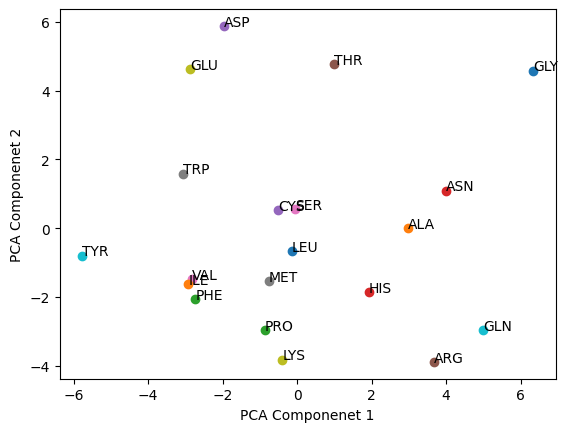

In [9]:
for j, i in enumerate(vis_dim):
    plt.scatter(i[0],i[1])
    plt.annotate(AAs[j],(i[0],i[1]))

plt.xlabel('PCA Componenet 1')
plt.ylabel('PCA Componenet 2')
plt.show()

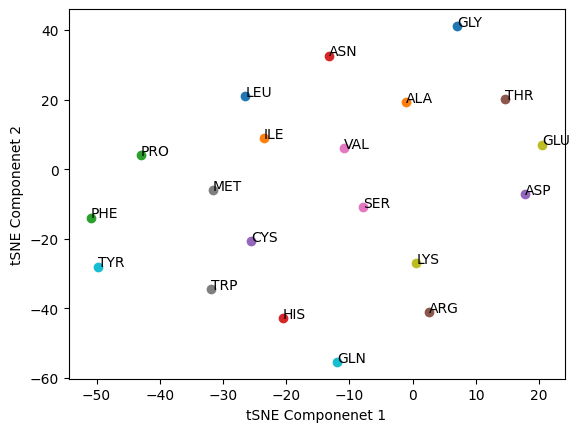

In [10]:
for j, i in enumerate(vis_dim_tsne):
    plt.scatter(i[0],i[1])
    plt.annotate(AAs[j],(i[0],i[1]))

plt.xlabel('tSNE Componenet 1')
plt.ylabel('tSNE Componenet 2')
plt.show()

In [11]:
tsne = TSNE(n_components = 3, perplexity=10.0)
pca = PCA(n_components = 3)
vis_dim = pca.fit_transform(matrix)
vis_dim_tsne = tsne.fit_transform(torch.Tensor(matrix))

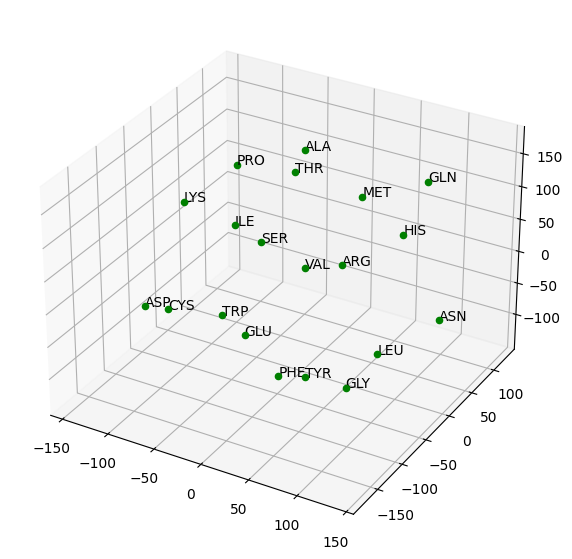

In [12]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
for j, i in enumerate(vis_dim_tsne):
    ax.scatter3D(i[0], i[1], i[2], color = "green")
    ax.text(i[0],i[1],i[2], AAs[j])

plt.show()

In [13]:
pdb_code = '1a1e'
pdb_filename = pdb_code+"_pocket_clean.pdb"
structure = Bio.PDB.PDBParser(QUIET = True).get_structure(pdb_code, (CFG.pdbfiles +'/'+pdb_code+'/'+pdb_filename))
model = structure[0]

In [14]:
def createMask(filename,graph,num_masked):
    pdb_code = filename
    pdb_filename = pdb_code+"_pocket_clean.pdb"
    structure = Bio.PDB.PDBParser(QUIET = True).get_structure(pdb_code, (CFG.pdbfiles +'/'+pdb_code+'/'+pdb_filename))
    model = structure[0]
    count = 0
    for chain in model:
        for resi in chain:
            count += 1
    protein_mask = [False]*(count - num_masked)
    true_mask = [True] * num_masked
    protein_mask = np.hstack((protein_mask,true_mask))
    random.shuffle(protein_mask)
    molecule_mask = [False]*(graph.x.size()[0] - count)
    
    return np.hstack((protein_mask,molecule_mask))

In [91]:
entry = random.choice(graph_list)

In [92]:
print(entry)

['6g3v', Data(x=[86, 133], edge_index=[2, 1891], edge_attr=[1891, 7])]


In [109]:
mask = createMask(entry[0],entry[1],1)

In [15]:
import pymol
from pymol import cmd

In [247]:
def myfunc(chain,resi):
    chain_list.append(chain)
    resi_list.append(resi)

myspace = {'myfunc': myfunc}

In [248]:
for filename in os.listdir(CFG.pdbfiles):
    print(filename)
    cmd.delete('all')
    pdb_filename = filename +'_pocket_clean.pdb'
    mol2_filename = filename+ '_ligand.mol2'
    cmd.load(CFG.pdbfiles +'/'+filename+'/'+pdb_filename)
    cmd.load(CFG.pdbfiles +'/'+filename+'/'+mol2_filename)
    cmd.create('interacting_resi', 'br. all within 5 of organic')
    chain_list = []
    resi_list = []
    cmd.iterate('interacting_resi', 'myfunc(chain,resi)', space=myspace)
    #cmd.iterate('interacting_resi', 'chain_list.append(chain)', space={'chain_list':chain_list})
    #cmd.iterate('interacting_resi', 'resi_list.append(resi)', space={'resi_list':resi_list})
    break

2wlz


In [249]:
chain_resi = []
previous = [None,None]
for i,resi in enumerate(resi_list):
    if chain_list[i]:
        test = [chain_list[i],resi_list[i]]
        if test != previous:
            chain_resi.append(test)
            previous = test
print(chain_resi)

['A','163'] in chain_resi

[['A', '163'], ['A', '167'], ['A', '172'], ['A', '191'], ['A', '207'], ['A', '273'], ['A', '274'], ['A', '275'], ['A', '276'], ['A', '277'], ['A', '313'], ['A', '315'], ['A', '362'], ['A', '388'], ['A', '390'], ['A', '391'], ['A', '444'], ['A', '446'], ['A', '473'], ['A', '476'], ['A', '539'], ['A', '540']]


True

In [250]:
structure = Bio.PDB.PDBParser(QUIET = True).get_structure(filename, (CFG.pdbfiles +'/'+filename+'/'+pdb_filename))
model = structure[0]
count = 0
designable_indicies = []
for chain in model:
    for resi in chain:
        test = [str(chain.id),str(resi.id[1])]
        #print(test)
        if test in chain_resi:
            designable_indicies.append(count)
            print(count)
        count += 1

print(designable_indicies)

0
2
3
6
10
15
16
17
18
19
23
25
29
32
33
34
41
43
45
48
53
54
[0, 2, 3, 6, 10, 15, 16, 17, 18, 19, 23, 25, 29, 32, 33, 34, 41, 43, 45, 48, 53, 54]


In [16]:
def design_indicies(filename):
    pdb_filename = filename +'_pocket_clean.pdb'
    mol2_filename = filename+ '_ligand.mol2'
    cmd.delete('all')
    cmd.load(CFG.pdbfiles +'/'+filename+'/'+pdb_filename)
    cmd.load(CFG.pdbfiles +'/'+filename+'/'+mol2_filename)
    cmd.create('interacting_resi', 'br. all within 5 of organic')
    chain_list = []
    resi_list = []
    cmd.iterate('interacting_resi', 'chain_list.append(chain)', space={'chain_list':chain_list,'resi_list':resi_list})
    cmd.iterate('interacting_resi', 'resi_list.append(resi)', space={'chain_list':chain_list,'resi_list':resi_list})
    
    chain_resi = []
    previous = [None,None]
    for i,resi in enumerate(resi_list):
        if chain_list[i]:
            test = [chain_list[i],resi_list[i]]
            if test != previous:
                chain_resi.append(test)
                previous = test
                
    structure = Bio.PDB.PDBParser(QUIET = True).get_structure(filename, (CFG.pdbfiles +'/'+filename+'/'+pdb_filename))
    model = structure[0]
    count = 0
    designable_indicies = []
    for chain in model:
        for resi in chain:
            test = [str(chain.id),str(resi.id[1])]
            if test in chain_resi:
                designable_indicies.append(count)
            count += 1
    
    return designable_indicies

In [17]:
indicies = design_indicies(filename)

In [18]:
print(indicies)

[5, 6, 7, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 34, 43, 44]


In [19]:
print(filename)

6qr2


In [20]:
count = 0
for i, entry in enumerate(graph_list_mn):
    indicies = design_indicies(entry.label)
    graph_list_mn[i].designable_indicies = indicies
    count += 1
    if count % 1000 == 0:
        print(count)

1000
2000
3000
4000
5000


In [22]:
smallest = 12
count = 0
for entry in graph_list_mn:
    if len(entry.designable_indicies) < smallest:
        count += 1

In [23]:
print(count)

282


In [25]:
torch.save(graph_list_mn, 'graphs_w_designable_indicies_mn_11172023')